# Set up notebook for colab

In [ ]:
# ch 4 page 163 - implement MNIST from scratch using all digits

In [1]:
!pip install -Uqq fastbook

     |████████████████████████████████| 727kB 16.1MB/s 
     |████████████████████████████████| 51kB 9.5MB/s 
     |████████████████████████████████| 1.2MB 44.4MB/s 
     |████████████████████████████████| 194kB 58.3MB/s 
     |████████████████████████████████| 61kB 10.6MB/s 


In [2]:
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [3]:
from fastai.vision.all import *

# Ingest data, get counts, set up train / valid x, y as tensors

In [4]:
path = untar_data(URLs.MNIST)

In [5]:
path

Path('/root/.fastai/data/mnist_png')

In [6]:
Path.BASE_PATH = path
path.ls()

(#2) [Path('training'),Path('testing')]

In [7]:
!ls {path}/'training/3' | wc -l

6131


In [8]:
!ls {path}/'training'

0  1  2  3  4  5  6  7	8  9


In [9]:
DIGITS = range(0, 10)

In [10]:
train_digit_paths = [(path/'training'/str(digit)).ls().sorted()
                        for digit in DIGITS]
valid_digit_paths = [(path/'testing'/str(digit)).ls().sorted()
                        for digit in DIGITS]

In [11]:
Image.open(train_digit_paths[9][-1])

In [12]:
# get stats on available data
for d in DIGITS:
    print('Train', d, len(train_digit_paths[d]))
for d in DIGITS:
    print('Valid', d, len(valid_digit_paths[d]))

Train 0 5923
Train 1 6742
Train 2 5958
Train 3 6131
Train 4 5842
Train 5 5421
Train 6 5918
Train 7 6265
Train 8 5851
Train 9 5949
Valid 0 980
Valid 1 1135
Valid 2 1032
Valid 3 1010
Valid 4 982
Valid 5 892
Valid 6 958
Valid 7 1028
Valid 8 974
Valid 9 1009


In [13]:
len(torch.cat([tensor([d] * len(train_digit_paths[d])) for d in DIGITS])), len(torch.cat([tensor([d] * len(valid_digit_paths[d])) for d in DIGITS]))

(60000, 10000)

In [14]:
# first attempt: made list of tensors
# next cell has the tensor of tensors version (using torch.cat())
'''train_x = [torch.stack([tensor(Image.open(img))
                          for img in train_digit_paths[d]])
                          for d in [3,7]]
type(train_x), train_x[1].shape'''

'train_x = [torch.stack([tensor(Image.open(img))\n                          for img in train_digit_paths[d]])\n                          for d in [3,7]]\ntype(train_x), train_x[1].shape'

In [15]:
train_x = torch.cat([torch.stack([tensor(Image.open(img))
                          for img in train_digit_paths[d]])
                          for d in DIGITS]).view(-1, 28*28).float()/255
valid_x = torch.cat([torch.stack([tensor(Image.open(img))
                          for img in valid_digit_paths[d]])
                          for d in DIGITS]).view(-1, 28*28).float()/255
train_x.shape, valid_x.shape

(torch.Size([60000, 784]), torch.Size([10000, 784]))

(torch.Size([28, 28]),
 <matplotlib.axes._subplots.AxesSubplot at 0x7f227f9aa9e8>)

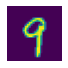

In [16]:
train_x[0].view(28,28).shape, show_image(train_x[-1].view(28,28))
# ??? show_image() more detailed and colorized, compared with Image.open()
# ??? all images in training data is greyscale - why is this colored?
# possible show_image() merely substituting b/w with green/yellow
# ??? but that does not explain purplish background color (equivalent of black)

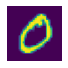

In [20]:
# show_image(train_x[0]) -- does not work
show_image(train_x[0].view(28,28))

In [21]:
train_y = torch.cat([tensor([d] * len(train_digit_paths[d])) for d in DIGITS]).unsqueeze(1)
valid_y = torch.cat([tensor([d] * len(valid_digit_paths[d])) for d in DIGITS]).unsqueeze(1)

In [22]:
train = list(zip(train_x, train_y))
valid = list(zip(valid_x, valid_y))

x, y = train[-1]
print(x.shape, y.shape)

torch.Size([784]) torch.Size([1])


# DL from scratch

In [23]:
# now on page 164
# need weights and bias for each pixel (initialized with random flloats of variance 1.0)
def init_parms(size, var=1.0):
    std = math.sqrt(var)
    return (torch.randn(size)*std).requires_grad_()

In [24]:
# initialze parameters
weights = init_parms((28*28, 1)) # note 2 parens - all get assigned to size
bias = init_parms(1)
print(weights.shape, bias.shape)

torch.Size([784, 1]) torch.Size([1])


In [25]:
# page 165
# define hidden linear layer
def linear1(x):
    return x@weights + bias

# get first prediction
preds = linear1(train_x)
preds

tensor([[ -9.2751],
        [-23.0076],
        [-15.8010],
        ...,
        [ -8.8975],
        [-10.6736],
        [ -6.4075]], grad_fn=<AddBackward0>)

In [33]:
# page 167 bottom
# define loss func as cross-entropy
# why? because no longer binary classification (3 vs 7), but multi-class classification (0 .. 9)
# from: https://machinelearningmastery.com/cross-entropy-for-machine-learning/
# cross-entropy is total entropy between two probability distributions
# is same as logistic loss or log loss (CE is from information theory; LL is from statistics)
# different from KL divergence: relative entropy between two probability distributions

# input: predictions, targets; output: loss
# def loss_func(x):
#     return exp(x) / exp(x).sum(dim=1, keepdim=True)

# calculate cross entropy
def cross_entropy(p, q):
	return -sum([p[i]*math.log(q[i]) for i in range(len(p))])

In [35]:
len(preds), len(train_y)

(60000, 60000)

In [36]:
ce_loss = nn.CrossEntropyLoss()

loss = ce_loss(preds, train_y)
loss

RuntimeError: ignored

In [37]:
from sklearn.metrics import log_loss

log_loss(tensor.detach().numpypreds, train_y)

RuntimeError: ignored

# Skipping for now - will work on mini-batch, SGD and return here

In [40]:
# DataLoader takes any python collection (list, dictionary, ...) and returns an iterator of 'chunks'
coll = string.ascii_letters # upper, lower: 52
dl = DataLoader(coll, batch_size=8, shuffle=True)

In [41]:
L(dl)

(#7) [['J', 'L', 'v', 'T', 'q', 'C', 'U', 'E'],['t', 'B', 'r', 'F', 'K', 'z', 'w', 'Q'],['X', 'h', 'M', 'f', 'b', 'y', 'Y', 'n'],['l', 'p', 'I', 'G', 'k', 'H', 'O', 'i'],['V', 'g', 'm', 'A', 'u', 'N', 'd', 's'],['S', 'e', 'a', 'D', 'W', 'P', 'Z', 'R'],['c', 'j', 'x', 'o']]

In [ ]:
# Datasets is a tuple of preds and targets
# when passed into a DataLoader returns batches of specified size

In [44]:
train_y[0].item()

0

In [45]:
# pseudo mnist_loss - force a binary classification
def mnist_loss(predictions, targets):
  preds = predictions.sigmoid()
  return torch.where(targets > 4, 1-preds, preds).mean()

In [50]:
# test on a small set
batch = train_x[:4]
print(batch.shape)

preds = linear1(batch)
print(preds)

loss = mnist_loss(preds, train_y[:4])
print(loss)

loss.backward()
print(weights.grad.mean(), bias.grad)

weights.grad.zero_()
bias.grad.zero_()

preds = linear1(batch)
print(preds)

loss = mnist_loss(preds, train_y[:4])
print(loss)
# second loss identical to first loss - we haven't applied our learning - we haven't taken an optimization step

torch.Size([4, 784])
tensor([[ -9.2751],
        [-23.0076],
        [-15.8010],
        [ -6.9643]], grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(8.9603e-05) tensor([0.0005])
tensor([[ -9.2751],
        [-23.0076],
        [-15.8010],
        [ -6.9643]], grad_fn=<AddBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)


In [55]:
# test on a small set
# this time, modify weights, bias a little in the 'right' direction
batch = train_x[:4]
print(batch.shape)

preds = linear1(batch)
print(preds)

loss = mnist_loss(preds, train_y[:4])
print(loss.item())

loss.backward()
# print(weights.grad.mean(), bias.grad)
weights.data -= weights.grad * 1e-1
bias.data -= bias.grad * 1e-1

weights.grad.zero_()
bias.grad.zero_()

preds = linear1(batch)
print(preds)

loss = mnist_loss(preds, train_y[:4])
print(loss.item())

# weights did change, but was not significant enough for change in loss
# until we use loss.item() - yay!

torch.Size([4, 784])
tensor([[ -9.2769],
        [-23.0088],
        [-15.8033],
        [ -6.9677]], grad_fn=<AddBackward0>)
0.0002586655900813639
tensor([[ -9.2785],
        [-23.0098],
        [-15.8054],
        [ -6.9707]], grad_fn=<AddBackward0>)
0.0002579112770035863


In [56]:
# test on a small set
# this time, modify weights, bias a little in the 'right' direction
# now, check metric (accuracy) on validation dataset
def batch_accuracy(xb, yb):
  preds = xb.sigmoid()
  correct = (preds > 4) == yb
  return correct.float().mean()

def validate_epoch(model):
  accs = [batch_accuracy(model(xb), yb) for xb,yb in valid]
  return torch.stack(accs).mean().item()

batch = train_x[:4]
print(batch.shape)

preds = linear1(batch)
print(preds)

loss = mnist_loss(preds, train_y[:4])
print(loss.item())
validate_epoch(linear1)

loss.backward()
# print(weights.grad.mean(), bias.grad)
weights.data -= weights.grad * 1e-1
bias.data -= bias.grad * 1e-1

weights.grad.zero_()
bias.grad.zero_()

preds = linear1(batch)
print(preds)

loss = mnist_loss(preds, train_y[:4])
print(loss.item())
validate_epoch(linear1)

# weights did change, but was not significant enough for change in loss
# until we use loss.item() - yay!
# accuracy (measured on valid) is also improving

torch.Size([4, 784])
tensor([[ -9.2785],
        [-23.0098],
        [-15.8054],
        [ -6.9707]], grad_fn=<AddBackward0>)
0.0002579112770035863
tensor([[ -9.2802],
        [-23.0108],
        [-15.8075],
        [ -6.9737]], grad_fn=<AddBackward0>)
0.0002571615332271904


0.09799999743700027

In [ ]:
# dls is a tuple of (train_dl, valid_dl)

# Bringing it all together with fastai constructs

In [60]:
dls = DataLoaders(
        DataLoader(dataset=train, batch_size=256, shuffle=True),
        DataLoader(dataset=valid, batch_size=256, shuffle=True))

In [61]:
learn = Learner(dls=dls,
                model=nn.Linear(28*28,1),
                opt_func=SGD,
                loss_func=mnist_loss,
                metrics=batch_accuracy)

In [62]:
lr = 1e-5
learn.fit(n_epoch=1, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.505390,0.506166,0.098000,00:01


In [63]:
learn.fit(20, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.505239,0.506036,0.098000,00:01
1,0.504690,0.505907,0.098000,00:01
2,0.504709,0.505777,0.098000,00:01
3,0.504801,0.505648,0.098000,00:00
4,0.504606,0.505519,0.098000,00:01
5,0.504464,0.505389,0.098000,00:01
6,0.504552,0.505260,0.098000,00:00
7,0.504229,0.505130,0.098000,00:01
8,0.503662,0.505001,0.098000,00:01
9,0.503902,0.504871,0.098000,00:01


In [64]:
learn.fit(20, lr=1e-3)
# loss coming down fast, but accuracy does not show improvement

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.492686,0.490639,0.098000,00:00
1,0.480585,0.477891,0.098000,00:01
2,0.468780,0.465517,0.098000,00:01
3,0.457616,0.453700,0.098000,00:01
4,0.446071,0.442527,0.098000,00:01
5,0.436384,0.432074,0.098000,00:01
6,0.426657,0.422337,0.098000,00:01
7,0.417202,0.413317,0.098000,00:01
8,0.408945,0.404976,0.098000,00:01
9,0.403085,0.397264,0.098000,00:01


In [65]:
# now introduce 2 layers - and an activation function in-between that will make a non-linear transformation
simple_net = nn.Sequential(
    nn.Linear(28*28, 10),
    nn.ReLU(),
    nn.Linear(10, 1)
)

In [67]:
learn2 = Learner(dls=dls,
                model=nn.Linear(28*28,1),
                opt_func=SGD,
                loss_func=mnist_loss,
                metrics=batch_accuracy)

learn2.fit(n_epoch=10, lr=1e-5)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.503249,0.505069,0.098000,00:01
1,0.503186,0.504940,0.098000,00:01
2,0.502797,0.504811,0.098000,00:01
3,0.502544,0.504682,0.098000,00:01
4,0.502883,0.504553,0.098000,00:01
5,0.502225,0.504425,0.098000,00:01
6,0.502931,0.504296,0.098000,00:01
7,0.502635,0.504167,0.098000,00:01
8,0.501924,0.504038,0.098000,00:01
9,0.502824,0.503910,0.098000,00:01


In [68]:
learn2.fit(n_epoch=10, lr=1e-3)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.492951,0.491054,0.098000,00:01
1,0.480410,0.478375,0.098000,00:01
2,0.468506,0.466090,0.098000,00:00
3,0.457170,0.454342,0.098000,00:01
4,0.446216,0.443255,0.098000,00:01
5,0.436754,0.432877,0.098000,00:01
6,0.427537,0.423225,0.098000,00:01
7,0.419444,0.414274,0.098000,00:01
8,0.411371,0.405991,0.098000,00:01
9,0.405037,0.398334,0.098000,00:01


In [ ]:
# accuracy is not improving because train_y and valid_y are not coded as 0/1 to match batch_accuracy function

In [ ]:
# check if batching needed at atll - i.e. use entire dataset

In [ ]:
# mini-batch desirable to fit into exisitng memory cpu/gpu and have reasonable runtime
# also permits iteration with shuffling
# need: item should be tuple of predictors and target
dl = DataLoader(train, batch_size=5, shuffle=True)
xb, yb = first(dl)
xb.shape, yb.shape
# DataLoaders() should be tuple of DataLoader() of (train, valid)

(torch.Size([5, 784]), torch.Size([5, 1]))

In [ ]:
# why increase layers > 2 (2 is sufficient for universal approximation theorem)
# increasing number of layers and reducing size of matrix (i.e. number of parameters)
# results in faster modeling and better results

In [71]:
doc(ImageDataLoaders)

In [73]:
!ls -l {path}

total 8
drwxr-x--- 12 1000 1000 4096 Dec 11  2015 testing
drwxr-x--- 12 1000 1000 4096 Dec 11  2015 training


In [74]:
!pwd

/content


In [75]:
!mv /root/.fastai/data/mnist_png/training /root/.fastai/data/mnist_png/train
!mv /root/.fastai/data/mnist_png/testing /root/.fastai/data/mnist_png/valid

In [77]:
path = untar_data(URLs.MNIST)
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(
    dls=dls,
    arch=resnet18,
    pretrained=False,
    loss_func=F.cross_entropy,
    metrics=accuracy
)

%time learn.fit(1, lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.057290,1.379927,0.903400,13:43


CPU times: user 13min 20s, sys: 15.1 s, total: 13min 36s
Wall time: 13min 43s


# If repeating, run setup section, then come here to check accuracy with resnet34, 10 epochs, with GPU

In [5]:
# check accuracy with resnet34, 10 epochs, with GPU
path = untar_data(URLs.MNIST)
!mv /root/.fastai/data/mnist_png/training /root/.fastai/data/mnist_png/train
!mv /root/.fastai/data/mnist_png/testing /root/.fastai/data/mnist_png/valid

In [6]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(
    dls=dls,
    arch=resnet34,
    pretrained=False,
    loss_func=F.cross_entropy,
    metrics=accuracy
)

%time learn.fit(10, lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,1.260315,5051.974609,0.851300,01:37
1,1.328297,0.904306,0.952800,01:37
2,1.412456,0.581038,0.961700,01:37
3,1.377956,0.958149,0.958700,01:38
4,1.205963,0.511055,0.972800,01:38
5,1.127403,4.126394,0.841600,01:37


epoch,train_loss,valid_loss,accuracy,time
0,1.260315,5051.974609,0.851300,01:37
1,1.328297,0.904306,0.952800,01:37
2,1.412456,0.581038,0.961700,01:37
3,1.377956,0.958149,0.958700,01:38
4,1.205963,0.511055,0.972800,01:38
5,1.127403,4.126394,0.841600,01:37
6,1.188774,2.491593,0.922100,01:38
7,1.089861,7.186997,0.953900,01:39
8,1.066417,105.314453,0.966200,01:38
9,1.324040,17.311258,0.949100,01:38


CPU times: user 13min 18s, sys: 13.1 s, total: 13min 31s
Wall time: 16min 22s


In [9]:
# how many samples were used from train / valid?  Were all digits tested?...
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

AssertionError: ignored

In [12]:
interp.most_confused(min_val=500)

AssertionError: ignored

In [13]:
# fastai default lr = 1e-3
%time learn.fit(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.367389,60.909405,0.986600,01:34
1,0.221221,0.132107,0.989300,01:35
2,0.213223,0.097647,0.990900,01:36
3,0.125374,0.082259,0.989800,01:36
4,0.123241,0.069624,0.990800,01:36
5,0.091902,0.052330,0.992200,01:38
6,0.069135,0.045744,0.992500,01:36
7,0.063114,0.039174,0.992700,01:35
8,0.065246,0.039401,0.991900,01:34
9,0.046662,0.035390,0.992300,01:34


CPU times: user 13min 4s, sys: 12.7 s, total: 13min 17s
Wall time: 16min


In [14]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0) 
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
print(f'Total:{t}, Reserved:{r}, Allocated:{a}, Free:{f}')

Total:15812263936, Reserved:436207616, Allocated:353519104, Free:82688512


In [15]:
!nvidia-smi
# Tesla T4

Sun Jan 31 03:53:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    32W /  70W |   1369MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
# init_params(torch.randn() * variance).requires_grad_() # variance, not std-dev

# matrix multiplication + summation: a@b: a.b(Transformed).sum() # we are able to take sum() because b is rank-1

# scalar ==> tensor of rank-0

# articulate why we cannot use accuracy as a loss function
# (step function, uses threshold, mostly grandient is zero, with a specific value when it is infinity)

# metric is the thing that you care about
# loss is the thing that behaves like the metric,
# i.e. must always go lower as metric gets 'better'
# additionally can be differentiated
# can always assert any loss function behaves such that lower is better

In [18]:
# first pass loss function - distance between preds and actuals - will work only with binary classfn. and if they are scaled between (0,1)

In [19]:
# advantage of sigmoid: converts to 0,1 1/1+exp(-x)

# use of sigmoid for classification is an activation function (computed; unlike parameters, not initialized or optimized)
# in this sense, MSE as a loss function is also an activation

# MSE is special because it can be the metric we care about and the loss function that is used by DL

# merely a 'convenient' loss function that can help us get closer to classification metrics

In [21]:
# when you see error like Long.. check if passing an integer (instead of a float) into torch

In [25]:
# batch_size can be entire ds if it can fit into CPU (GPU) memory
#??? is there a problem if bs is not uniform?
# Only in extreme cases: last batch will have <bs, so iteration will degrade
# this can be seen as a positve (perturbation or deliberate introduction of stochasticity)

# if whole, then GD; if mini-batch, then SGD

In [26]:
# median not a good choice over mean - median cares only about one number (after sorting)
# while mean is sensitive to outliers, it is expected to 'even out' over repeated runs over large number of samples
# i.e. algo 'learns' which obs are outliers and downgrades them (?)
# also median would behave like a threshold and give gradient of zero most of the time

In [27]:
# nn.Linear() sets up x@w+b and initializes w and b

# ReLU works as long as significant number of parameters don't end up as zero
# these 'dead' neurons lead to wasted computations
# good idea to detect and track, and figure out ways to keep it from exceeding threshold

# generally choice of ReLU, tanh, leaky ReLU, ... does not change much on a per-problem basis
# there are general properties (train faster, get more accurate results, ...) that are 'known' for each choice

# As layers increase, use smaller lr - the architecture becomes more complex and less stable
learn.recorder.values

[(#3) [0.3673885464668274,60.90940475463867,0.9865999817848206],
 (#3) [0.2212211638689041,0.13210734724998474,0.989300012588501],
 (#3) [0.2132231742143631,0.09764749556779861,0.9908999800682068],
 (#3) [0.12537430226802826,0.08225882798433304,0.989799976348877],
 (#3) [0.12324110418558121,0.06962434202432632,0.9908000230789185],
 (#3) [0.09190214425325394,0.052330274134874344,0.9922000169754028],
 (#3) [0.06913508474826813,0.045744072645902634,0.9925000071525574],
 (#3) [0.06311431527137756,0.039174433797597885,0.9926999807357788],
 (#3) [0.06524591147899628,0.03940147906541824,0.9919000267982483],
 (#3) [0.04666249081492424,0.035389792174100876,0.9922999739646912]]

In [29]:
L(learn.recorder.values).itemgot(2)

(#10) [0.9865999817848206,0.989300012588501,0.9908999800682068,0.989799976348877,0.9908000230789185,0.9922000169754028,0.9925000071525574,0.9926999807357788,0.9919000267982483,0.9922999739646912]

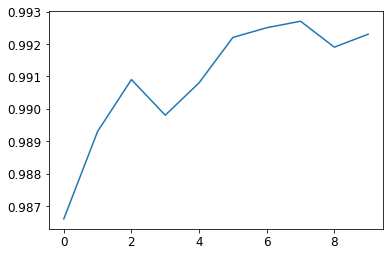

In [30]:
plt.plot(L(learn.recorder.values).itemgot(2))

In [36]:
itemgetter??

In [39]:
learn.recorder.values[-1][2]

0.9922999739646912

In [42]:
model = learn.model

In [43]:
model[0] # first layer

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [44]:
model[0].parameters

<bound method Module.parameters of Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): Re

In [50]:
w = model[0].parameters()
type(w)

generator

In [55]:
len([w])

1